# Entanglement Classifier Training Trial

## Importing Dependencies

In [1]:
import numpy as np

from classifier.components.system import System
from classifier.components.interaction import InteractionFactory
from classifier.components.model import Model
from classifier.components.interaction_functions import CascadeFunction, EnergyExchangeFunction, DampingFunction
from classifier.components.reservoir_analysis import ReservoirAnalyser

from quantum.core import GeneralQubitMatrixGen, DensityMatrix

## Constructing Reservoirs

### System Parameters

In [2]:
reservoir_nodes=[4]
system_nodes=2

### Setting up the interface

In [3]:
"""
Defining Interface setup
"""

interfaceFactory = InteractionFactory(EnergyExchangeFunction, coupling_strength=0.5)

### Setting up the reservoir

In [4]:
"""
Defining Reservoir setup
"""

reservoirFactory1 = InteractionFactory(EnergyExchangeFunction, coupling_strength=[0.5,1])
reservoirFactory2 = InteractionFactory(DampingFunction, damping_strength=1)

### Setting up the model

In [5]:
node_pairs = [
            [sys_node, res_node]
            for sys_node in [0,1]
            for res_node in [2,3,4]
        ]

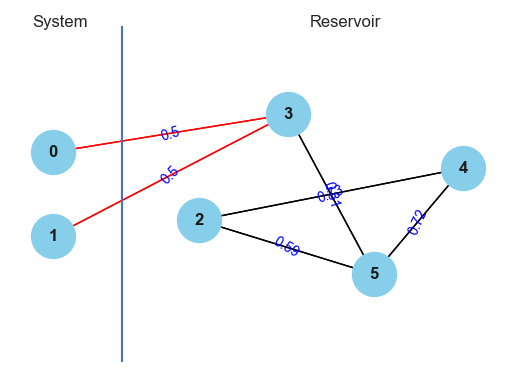

In [6]:
reservoirs = []

for n_reservoir_nodes in reservoir_nodes:
    """
    Defining System setup
    """

    system_state = DensityMatrix(np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))
    system_node_list = [0, 1]

    if len(system_node_list) != system_nodes:
        raise Exception

    #system_interactions = {"sys_interaction_0" : Interaction(0, DampingFunction(0, n_reservoir_nodes+system_nodes, 1)),
    #                    "sys_interaction_1" : Interaction(1, DampingFunction(1, n_reservoir_nodes+system_nodes, 1))}

    system_interactions = {}
    system = System(
        init_quantum_state=system_state, nodes=system_node_list, interactions=system_interactions
    )



    model = Model()
    model.setSystem(system)
    model.setReservoirInteractionFacs(dualFactories=[reservoirFactory1], singleFactories=[])
    model.setInterfaceInteractionFacs([interfaceFactory])
    model.generateReservoir(n_reservoir_nodes, init_quantum_state=0, interaction_rate=n_reservoir_nodes)
    model.generateInterface(interaction_rate=system_nodes)
    model.setRunDuration(2)
    model.setRunResolution(0.2)
    model.setSwitchStructureTime(2)

    reservoirs.append(model)

    G = model.draw()

In [7]:
analyser = ReservoirAnalyser(reservoirs)

In [18]:
import pickle

with open(r'C:\Users\mmack\Documents\Repos\qreservoir_computing\data\2_qubit_dataset.pkl', 'rb') as file:
            analyser.states = pickle.load(file)

In [19]:
import pickle
import os

analyser.datasets = []

for file in os.listdir(r'C:\Users\mmack\Documents\Repos\qreservoir_computing\datasets'):
    with open(os.path.join(r'C:\Users\mmack\Documents\Repos\qreservoir_computing\datasets', file), 'rb') as file:
                analyser.datasets.append(pickle.load(file))



In [20]:
for dataset in analyser.datasets:
    print(len(dataset.x_train), dataset.score)

450000 0.9816952539479151
90000 0.5958006772951769
90000 0.595639765558721
90000 0.9700747643826302
90000 0.9801596948497215
90000 0.9746427186086221
90000 0.9768506263430974


In [28]:
analyser.datasets.pop(3)

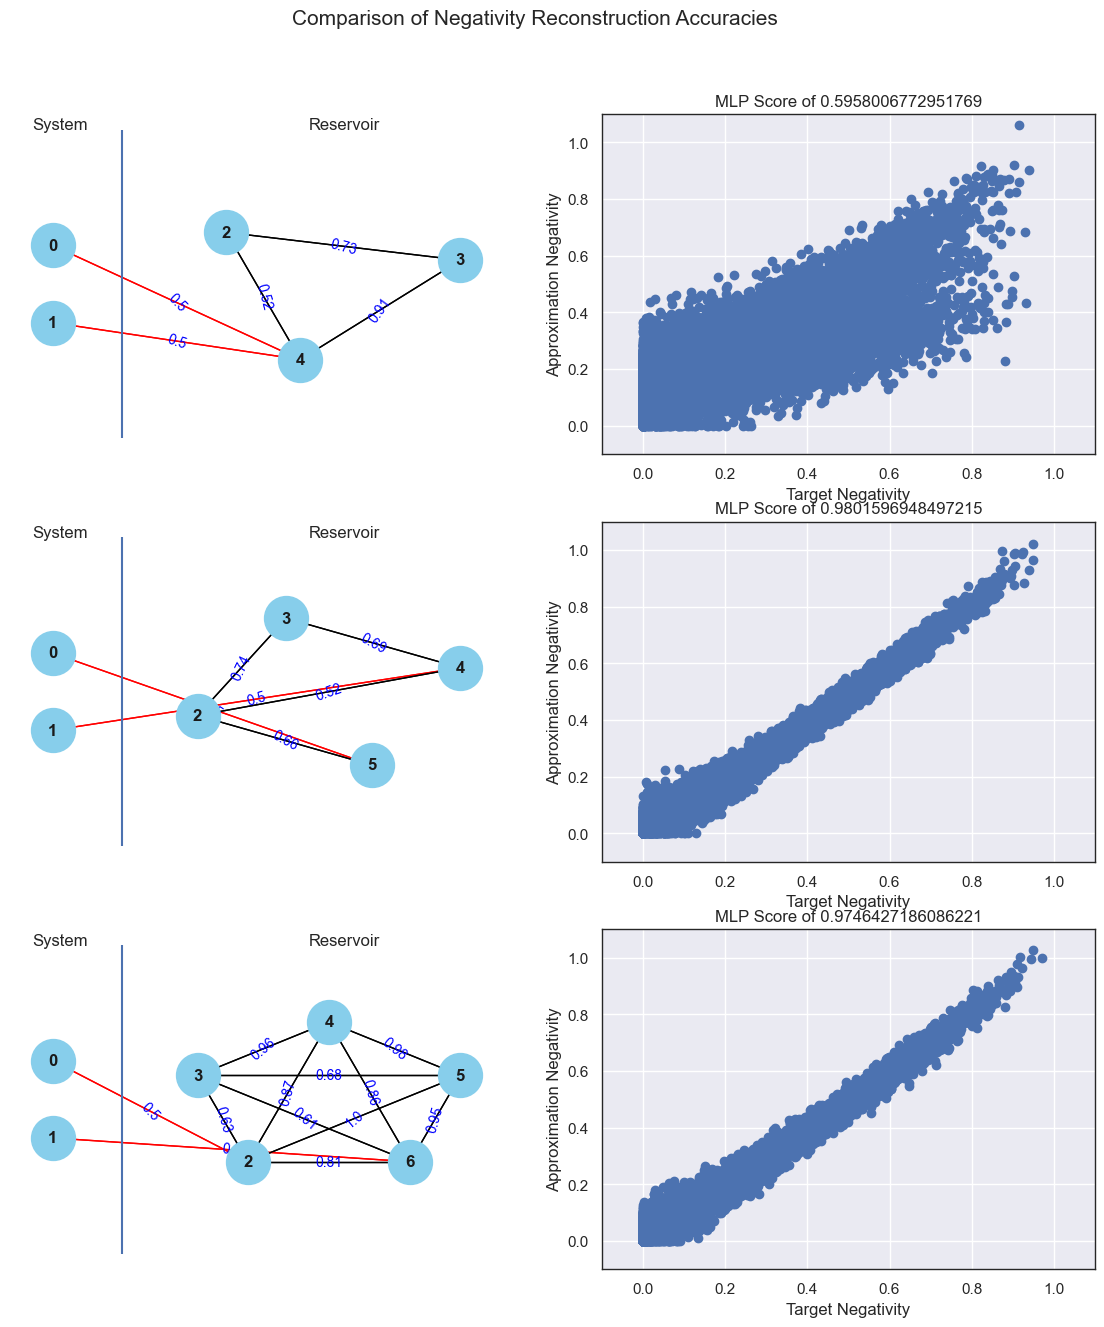

In [29]:
analyser.compare()

In [24]:
analyser.generateStates(500000, n_qubits=2, state_subset="general")

In [20]:
with open(r'C:\Users\mmack\Documents\Repos\qreservoir_computing\data\2_qubit_large_dataset.pkl', 'wb') as file:
        pickle.dump(analyser.states, file)

In [53]:
state_copy = analyser.states

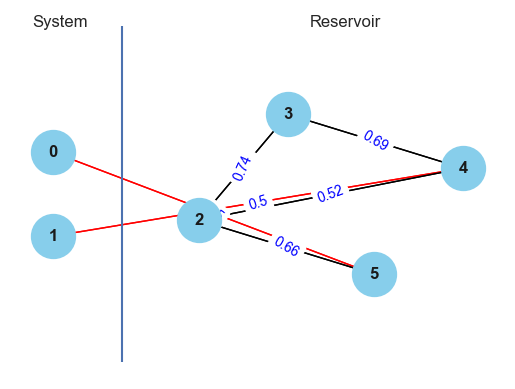

In [27]:
analyser.reservoirs[0].draw()

In [54]:
analyser.states = state_copy

In [19]:
analyser.transformStates(multiprocess=False)

Transforming reservoir 1 of 1


  0%|          | 194/500000 [00:12<9:03:30, 15.33it/s]


KeyboardInterrupt: 

with open(f'/Users/matthewmackinnon/Documents/repos/entanglement_classifier_redesign/data/4_qubit_reservoir.pkl', 'wb') as file:
        pickle.dump(analyser.datasets[0].transformed_states, file)

## Classical Processing

In [14]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR

In [15]:
dataset = analyser.datasets[2]

x = dataset.target_states
d = dataset.transformed_states
y = [state.negativity() for state in x]

x_train, x_test, y_train, y_test = train_test_split(d, y, test_size=0.1)

In [16]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler().fit(np.real(x_train))

In [49]:
mlp = RandomForestRegressor().fit(scaler.transform(np.real(x_train)), y_train)
mlp.score(scaler.transform(np.real(x_train)), y_test)

TypeError: float() argument must be a string or a real number, not 'DensityMatrix'

In [17]:
import matplotlib.pyplot as plt

In [18]:
import pandas as pd

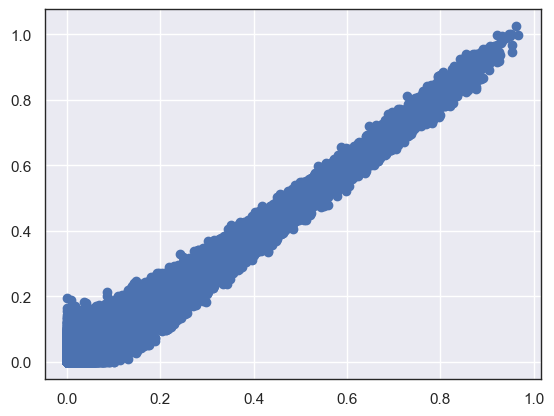

In [48]:
dataset=analyser.datasets[2]
plt.scatter(dataset.y_test, [0 if pred < 0 else pred for pred in dataset.mlp.predict(dataset.x_test)])

In [24]:
gen = GeneralQubitMatrixGen()

In [43]:
x_train = [gen.generateState(2) for i in range(10000)]
y_train = [state.negativity() for state in x_train]

(array([1674.,  732.,  799.,  844.,  797.,  721.,  733.,  678.,  620.,
         560.,  452.,  402.,  294.,  224.,  192.,  122.,   75.,   52.,
          23.,    6.]),
 array([0.        , 0.04748958, 0.09497916, 0.14246873, 0.18995831,
        0.23744789, 0.28493747, 0.33242705, 0.37991662, 0.4274062 ,
        0.47489578, 0.52238536, 0.56987494, 0.61736451, 0.66485409,
        0.71234367, 0.75983325, 0.80732283, 0.8548124 , 0.90230198,
        0.94979156]),
 <BarContainer object of 20 artists>)

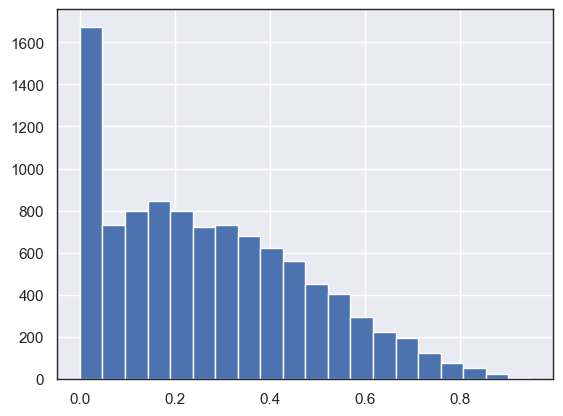

In [44]:
import numpy as np
plt.hist(y_train, bins=20)

In [45]:
dataset.score

0.9801596948497215

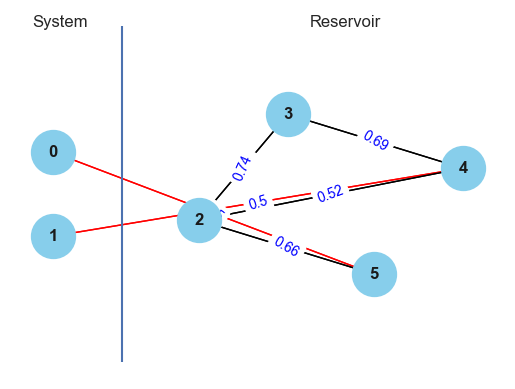

In [48]:
dataset.reservoir.draw()

In [ ]:
import seaborn as sns

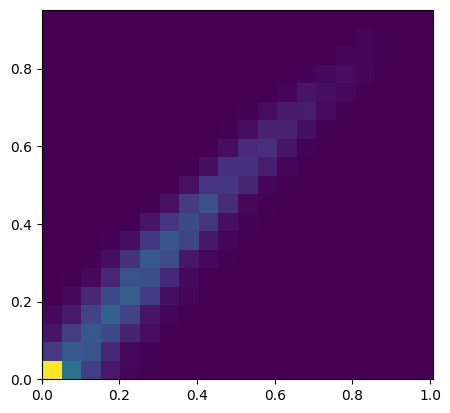

In [ ]:
heatmap, xedges, yedges = np.histogram2d([0 if pred < 0 else pred for pred in mlp.predict(x_test)], y_test, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [ ]:
np.array(y_test).shape

(10000,)

In [ ]:
np.array(y_test)[np.array(y_test) <= 0.8].shape

(9924,)

In [ ]:
pd.DataFrame(np.array([np.round(y_test, 2), np.round([0 if pred < 0 else pred for pred in mlp.predict(x_test)],2)]).T, columns=['Target', 'Prediction']).value_counts()

Target  Prediction
0.00    0.00          472
        0.01           69
        0.02           64
        0.03           56
        0.05           44
                     ... 
0.39    0.24            1
        0.46            1
        0.50            1
        0.52            1
0.95    0.91            1
Name: count, Length: 1931, dtype: int64

In [ ]:
np.round(y_test, 2)